In [1]:
from IPython import display
%matplotlib inline
import cv2
import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, sys, shutil
import torch
import omegaconf
import time
import torch

import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util

import tactile_gym.rl_envs
from tactile_gym.sb3_helpers.params import import_parameters

%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# produce a display to render image
from pyvirtualdisplay import Display
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

# Setup Training Environment and Parameters

In [3]:
# Make the pushing environment
algo_name = 'ppo'
env_name = 'object_push-v0'
rl_params, algo_params, augmentations = import_parameters(env_name, algo_name)
rl_params["env_modes"][ 'observation_mode'] = 'tactile_pose_data'
rl_params["env_modes"][ 'control_mode'] = 'TCP_position_control'
# rl_params["env_modes"]['movement_mode'] = 'TxTyRz'
rl_params["env_modes"][ 'terminate_early']  = True
rl_params["env_modes"][ 'use_contact'] = True
rl_params["env_modes"][ 'traj_type'] = 'point'
rl_params["env_modes"]['task'] = "goal_pos",
print(rl_params)
print(algo_params)

env_kwargs={
    'show_gui':False,
    'show_tactile':False,
    'max_steps':rl_params["max_ep_len"],
    'image_size':rl_params["image_size"],
    'env_modes':rl_params["env_modes"],
}
env = gym.make(env_name, **env_kwargs)

seed = 0
env.seed(seed)
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

# This functions allows the model to evaluate the true rewards given an observation 
reward_fn = reward_fns.cartpole
# This function allows the model to know if an observation should make the episode end
term_fn = termination_fns.cartpole

# Define model working directorys
work_dir = os.path.join(os.getcwd(), 'saved_model')
if not os.path.exists(work_dir):
    os.mkdir(work_dir)

{'algo_name': 'ppo', 'env_name': 'object_push-v0', 'max_ep_len': 1000, 'image_size': [128, 128], 'env_modes': {'movement_mode': 'TyRz', 'control_mode': 'TCP_position_control', 'rand_init_orn': False, 'rand_obj_mass': False, 'traj_type': 'point', 'observation_mode': 'tactile_pose_data', 'reward_mode': 'dense', 'terminate_early': True, 'use_contact': True, 'task': ('goal_pos',)}, 'policy': 'MultiInputPolicy', 'seed': 1, 'n_stack': 1, 'total_timesteps': 1000000, 'n_eval_episodes': 10, 'n_envs': 10, 'eval_freq': 2000.0}
{'policy_kwargs': {'features_extractor_class': <class 'tactile_gym.sb3_helpers.custom.custom_torch_layers.CustomCombinedExtractor'>, 'features_extractor_kwargs': {'cnn_base': <class 'stable_baselines3.common.torch_layers.NatureCNN'>, 'cnn_output_dim': 256, 'mlp_extractor_net_arch': [64, 64]}, 'net_arch': [{'pi': [256, 256], 'vf': [256, 256]}], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>}, 'learning_rate': 0.0003, 'n_steps': 2048, 'batch_size': 64, 'n_epochs'

pybullet build time: Mar  8 2021 17:26:24


ven = NVIDIA Corporation
ven = NVIDIA Corporation


In [4]:
print(env.reset())
print(env.get_oracle_obs())
print(type(env.get_oracle_obs()))

[-0.160609 -0.089999 0.000000 0.000000 0.000000 -0.364894 0.931049
 -0.160476 -0.090000 0.000000 0.000000 0.000000 -0.364894 0.931049]
[0.000867 0.000001 -0.000001 -0.000002 -0.000001 -0.000000 0.008629
 -0.000057 0.000049 0.000118 0.000079 0.000011 0.001000 0.000000 0.000000
 0.000000 -0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.161476 0.090000 0.000000 0.000000 0.000000 0.747038]
<class 'numpy.ndarray'>


In [5]:
print(env.observation_space)
print(env.action_space)
print(obs_shape)
print(act_shape)

Box(14,)
Box(2,)
(14,)
(2,)


In [6]:
trial_length = 1000
num_trials = 30
ensemble_size = 5
initial_buffer_size = 1000
buffer_size = 10000
target_normalised = True

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": "???",
        "out_size": "???",
        "deterministic": False,
        "propagation_method": "fixed_model",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
        "target_normalize": target_normalised,
        "dataset_size": buffer_size
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 32,
        "validation_ratio": 0.05
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

In [7]:
# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnvPushing(env, dynamics_model, termination_fn=None, reward_fn=None, generator=generator)

print(dynamics_model)

/home/qt21590/anaconda3/envs/tactile_gym_mbrl/lib/python3.9/site-packages/hydra/utils.py:32: UserWarning: `OmegaConf.is_none()` is deprecated, see https://github.com/omry/omegaconf/issues/547
  if OmegaConf.is_none(config):


OneDTransitionRewardModel(
  (model): GaussianMLP(
    (hidden_layers): Sequential(
      (0): Sequential(
        (0): EnsembleLinearLayer(num_members=5, in_size=16, out_size=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): EnsembleLinearLayer(num_members=5, in_size=200, out_size=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): EnsembleLinearLayer(num_members=5, in_size=200, out_size=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (mean_and_logvar): EnsembleLinearLayer(num_members=5, in_size=200, out_size=28, bias=True)
  )
)


In [8]:
replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)
common_util.rollout_agent_trajectories(
    env,
    initial_buffer_size, # initial exploration steps
    planning.RandomAgent(env),
    {}, # keyword arguments to pass to agent.act()
    replay_buffer=replay_buffer,
    trial_length=trial_length
)

print("# samples stored", replay_buffer.num_stored)

# samples stored 1000


In [9]:
agent_cfg = omegaconf.OmegaConf.create({
    # this class evaluates many trajectories and picks the best one
    "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
    "planning_horizon": 10,
    "replan_freq": 1,
    "verbose": False,
    "action_lb": "???",
    "action_ub": "???",
    # this is the optimizer to generate and choose a trajectory
    "optimizer_cfg": {
        "_target_": "mbrl.planning.CEMOptimizer",
        "num_iterations": 5,
        "elite_ratio": 0.1,
        "population_size": 500,
        "alpha": 0.1,
        "device": device,
        "lower_bound": "???",
        "upper_bound": "???",
        "return_mean_elites": True,
        "clipped_normal": False
    }
})

agent = planning.create_trajectory_optim_agent_for_model(
    model_env,
    agent_cfg,
    num_particles=20
)

In [10]:
# Saving config files
config_filename = 'cfg_dict'
config_dir = os.path.join(work_dir, config_filename)
omegaconf.OmegaConf.save(config=cfg, f=config_dir) 
loaded = omegaconf.OmegaConf.load(config_dir)
assert cfg == loaded

agent_config_filename = 'agent_cfg'
agent_config_dir = os.path.join(work_dir, agent_config_filename)
omegaconf.OmegaConf.save(config=agent_cfg, f=agent_config_dir) 
loaded = omegaconf.OmegaConf.load(agent_config_dir)
assert agent_cfg == loaded

env_kwargs_filename = 'env_kwargs'
env_kwargs_dir = os.path.join(work_dir, env_kwargs_filename)
omegaconf.OmegaConf.save(config=env_kwargs, f=env_kwargs_dir) 
loaded = omegaconf.OmegaConf.load(env_kwargs_dir)
assert env_kwargs == loaded

In [ ]:
# env.update_trajectory()
print(env.get_obj_pos_workframe())
print(env.cur_obj_pos_worldframe)
print(env.xyz_obj_dist_to_goal())
env.reset()
(
    tcp_pos_workframe,
    _,
    _,
    _,
    _,
) = env.robot.arm.get_current_TCP_pos_vel_workframe()
print(tcp_pos_workframe)
print(env.get_obj_pos_workframe())
print(env.cur_obj_pos_worldframe)
print(env.xyz_obj_dist_to_goal())
for i in range(10):
    action = np.zeros(3)
    action[0] = -0.1
    _, _, done, _ = env.step(action)
    print(env._sim_time_step)


(array([0.197991, -0.002201, -0.000003]), (-6.402761411452523e-07, 1.1395634390898269e-06, 0.16944171465938263, 0.9855402099009354))
[0.547799 0.047991 0.040003]
0.09346806830530063
[0.000867 0.000001 -0.000001]
(array([0.001000, 0.000000, 0.000000]), (0.0, 0.0, 0.0, 1.0))
[0.550000 -0.149000 0.040000]
0.2895609787600035
0.004166666666666667
0.004166666666666667
0.004166666666666667
0.004166666666666667
0.004166666666666667
0.004166666666666667
0.004166666666666667
0.004166666666666667
0.004166666666666667
0.004166666666666667


In [14]:
# fig, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
# ax_text = axs[0].text(130, 80, "")
# ax_text.set_color('white')

# Main PETS loop
all_rewards = [0]
plan_time = 0.0
train_time = 0.0
for trial in range(1):
    obs = env.reset()    
    # agent.reset()
    
    done = False
    total_reward = 0.0
    steps_trial = 0
    while not done:

        # axs[0].imshow(env.render(mode="rgb_array"))
        # display.display(plt.gcf())  
        # display.clear_output(wait=True)
        
        action = np.zeros(3)
        action[0] = -0.1
        next_obs, reward, done, _ = env.step(action)
        # print(env.get_obj_pos_worldframe())
        # print(env.get_obj_pos_workframe())
        # print(env.xyz_obj_dist_to_goal())
        # (
        #     tcp_pos_workframe,
        #     _,
        #     _,
        #     _,
        #     _,
        # ) = env.robot.arm.get_current_TCP_pos_vel_workframe()
        # print(tcp_pos_workframe)
        print(reward)

        obs = next_obs
        total_reward += reward
        steps_trial += 1

        if steps_trial == trial_length:
            break
    
    all_rewards.append(total_reward)


print(env.get_obj_pos_worldframe())
print(env.xyz_obj_dist_to_goal())
print(env.cur_obj_pos_worldframe)
print(env.targ_traj_list_id)
print(env._env_step_counter)
(
    tcp_pos_workframe,
    _,
    _,
    _,
    _,
) = env.robot.arm.get_current_TCP_pos_vel_workframe()
print(tcp_pos_workframe)

-0.619978425453319
-0.619978133856788
-500.6199769539893
(array([0.550000, -0.149002, 0.039987]), array([0.707107, 0.707107, 0.000018, -0.000015]))
0.29979680682228643
[0.550000 -0.149002 0.039987]
0
3
[-0.000281 0.000000 -0.000000]


# Environment Tests

In [11]:
env.reset()
print("Current goal index", env.targ_traj_list_id)
print("Position goal trajectory", env.traj_pos_workframe)
# print("Orientation goal trajectory", env.traj_rpy_workframe)
# print("Orientation goal trajectory", env.traj_orn_workframe)

# All of this can be accessed through model_env.env
print(model_env.env.targ_traj_list_id)
print(model_env.env.traj_pos_workframe == env.traj_pos_workframe)
print(model_env.env.goal_pos_workframe)

Current goal index 0
Position goal trajectory [[0.290000 0.042504 0.000000]]
0
[[ True  True  True]]
[0.290000 0.042504 0.000000]


In [12]:
# ----------------- Test termination function in model env -------------------------
early_termination = env.terminate_early
def termination(act: torch.Tensor, next_obs: torch.Tensor, rewards:  torch.Tensor) -> torch.Tensor:
    '''
    Criteria for terminating an episode. Should return a vector of dones of size 
    population_size x batch_size
    '''

    if 'reduced' in env.observation_mode: 
        tcp_pos_to_goal_workframe = next_obs[:, 0:3]
        # tcp_orn_to_goal_workframe = next_obs[:, 3:7]
        # tcp_lin_vel_workframe = next_obs[:, 7:10]
        # tcp_ang_vel_workframe = next_obs[:, 10:13]
        cur_obj_pos_to_goal_workframe = next_obs[:, 13:16]
        # cur_obj_orn_to_goal_workframe = next_obs[:, 16:20]
        # cur_obj_lin_vel_workframe = next_obs[:, 20:23]
        # cur_obj_ang_vel_workframe = next_obs[:, 23:26]

        tcp_pos_workframe = tcp_pos_to_goal_workframe + goal_pos_workframe_batch
        cur_obj_pos_workframe = cur_obj_pos_to_goal_workframe + goal_pos_workframe_batch

        # Calculate distance between goal and current positon
        obj_goal_pos_dist = torch.linalg.norm(cur_obj_pos_to_goal_workframe, axis=1)
    
    elif 'tactile_pose' in env.observation_mode: 
        tcp_pos_to_goal_workframe = next_obs[:, 0:3]
        # tcp_orn_to_goal_workframe = next_obs[:, 3:7]
        cur_obj_pos_to_goal_workframe = next_obs[:, 7:10]
        # cur_obj_orn_to_goal_workframe = next_obs[:, 10:14]

        # Only take in the x and y coordinates
        tcp_pos_workframe = tcp_pos_to_goal_workframe[:, 0:2] + goal_pos_workframe_batch[:, 0:2]
        cur_obj_pos_workframe = cur_obj_pos_to_goal_workframe[:, 0:2] + goal_pos_workframe_batch[:, 0:2]
        # Calculate distance between goal and current positon
        obj_goal_pos_dist = torch.linalg.norm(cur_obj_pos_to_goal_workframe, axis=1)

    else:
        tcp_pos_workframe = next_obs[:, 0:3]
        # tcp_rpy_workframe = next_obs[:, 3:6]
        # tcp_lin_vel_workframe = next_obs[:, 6:9]
        # tcp_ang_vel_workframe = next_obs[:, 9:12]
        cur_obj_pos_workframe = next_obs[:, 12:15]
        # cur_obj_rpy_workframe = next_obs[:, 15:18]
        # cur_obj_lin_vel_workframe = next_obs[:, 18:21]
        # cur_obj_ang_vel_workframe = next_obs[:, 21:24]
        # pred_goal_pos_workframe = next_obs[:, 24:27]
        # pred_goal_rpy_workframe = next_obs[:, 27:30]

        # Calculate distance between goal and current positon
        obj_goal_pos_dist = torch.linalg.norm(cur_obj_pos_workframe - goal_pos_workframe_batch, axis=1)
    
    # print('Object position, ', cur_obj_pos_workframe)
    # print('TCP position, ', tcp_pos_workframe)

    # Set obj to goal to smaller than tolerance for testing
    # obj_goal_pos_dist[1] = 0.001

    # intiailise terminated vector
    terminated = torch.zeros((batch_size, 1), dtype=bool).to(device)

    # print("goal position batch before update \n", goal_pos_workframe_batch)
    # print("goal index batch before update", targ_traj_list_id_batch)

    # Early termination if outside of the tcp limits
    if early_termination:
        outside_tcp_lims_idx = outside_tcp_lims(tcp_pos_workframe, cur_obj_pos_workframe)
        terminated[outside_tcp_lims_idx] = True
        rewards[outside_tcp_lims_idx] -= env.terminated_early_penalty
        # print("Outside TPC_lims, ", outside_tcp_lims(tcp_pos_workframe, cur_obj_pos_workframe))

    # update goals index if subgoal reached
    targ_traj_list_id_batch[obj_goal_pos_dist < model_env.termination_pos_dist] += 1

    # Terminated is true if last subgoal is reached
    terminated[targ_traj_list_id_batch >= model_env.traj_n_points] = True

    # Update goal position batch for none terminated samples
    goal_pos_workframe_batch[~terminated[:,0]] = traj_pos_workframe[targ_traj_list_id_batch[~terminated[:,0]]]

    # print("obj to goal distance", obj_goal_pos_dist)
    # print("goal index batch", targ_traj_list_id_batch)
    # print("terminated batch", terminated)
    # print("goal position index not terminated", targ_traj_list_id_batch[~terminated[:,0]])
    # print("The none terminated goals to be updated", traj_pos_workframe[targ_traj_list_id_batch[~terminated[:,0]]])
    # print("The updated goals \n", goal_pos_workframe_batch)
    return terminated

def outside_tcp_lims(tcp_pos_workframe, cur_obj_pos_workframe):
    # xyz_tcp_dist_to_obj = torch.linalg.norm(tcp_pos_workframe - cur_obj_pos_workframe)
    return ((tcp_pos_workframe[:, 0] < env.robot.arm.TCP_lims[0,0]) | 
        (tcp_pos_workframe[:, 0] > env.robot.arm.TCP_lims[0,1]) | 
        (tcp_pos_workframe[:, 1] < env.robot.arm.TCP_lims[1,0]) | 
        (tcp_pos_workframe[:, 1] > env.robot.arm.TCP_lims[1,1]) | 
        (cur_obj_pos_workframe[:, 0] < env.robot.arm.TCP_lims[0,0]) | 
        (cur_obj_pos_workframe[:, 0] > env.robot.arm.TCP_lims[0,1]) | 
        (cur_obj_pos_workframe[:, 1] < env.robot.arm.TCP_lims[1,0]) | 
        (cur_obj_pos_workframe[:, 1] > env.robot.arm.TCP_lims[1,1])) 
        # (xyz_tcp_dist_to_obj > env.obj_width / 2))                # TODO: exiting episode when roughly lose contact


# Reset environment
batch_size = 3
env.reset()
model_env.reset_batch_goals(batch_size)

# Create goal batches (access through model_env)
traj_pos_workframe = model_env.traj_pos_workframe.clone()
goal_pos_workframe_batch = model_env.goal_pos_workframe_batch.clone()
targ_traj_list_id_batch = model_env.targ_traj_list_id_batch
# targ_traj_list_id_batch = torch.from_numpy(targ_traj_list_id_batch).long()
# targ_traj_list_id_batch[0] = 11

obs = torch.randn(batch_size, obs_shape[0]).to(device)
if "reduced" in env.observation_mode:
    obs[:, :3] =  torch.tensor([[0.2, 0.05, 0.1], [0.2, 0.05, 0.1], [0.2, 0.05, 0.1]]) 
    obs[:, 13:16] = torch.tensor([[0.2, 0.05, 0.1], [0.2, 0.1, 0.1], [0.2, 0.05, 0.1]])
elif 'tactile_pose' in env.observation_mode: 
    obs[:, 0:2] =  torch.tensor([[0.20, 0.01], [0.2, 0.01], [0.2, 0.01]]) 
    obs[:, 7:9] = torch.tensor([[0.2, 0.01], [0.20, 0.01], [0.2, 0.01]])
else:
    obs[:, :3] =  torch.tensor([[0.3, 0.1, 0.1], [0.3, 0.1, 0.1], [0.3, 0.1, 0.1]]) 
    obs[:, 12:15] = torch.tensor([[0.3, 0.1, 0.1], [0.3, 0.1, 0.1], [0.4, 0.1, 0.1]]) 

act = torch.randn(batch_size, 1).to(device)
rewards_test = torch.zeros(batch_size, 1).to(device)
rewards_push = torch.zeros(batch_size, 1).to(device)
print(termination(act, obs, rewards_test))
print(model_env.termination(act, obs, rewards_push))
print(rewards_test)
print(rewards_push)

tensor([[True],
        [True],
        [True]], device='cuda:0')
tensor([[True],
        [True],
        [True]], device='cuda:0')
tensor([[0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[0.],
        [0.],
        [0.]], device='cuda:0')


In [13]:
# ---------------- Test early termination ------------------------
early_termination = True

tcp_pos_workframe = torch.tensor([[0.2, 0.05, 0.1], [0.2, 0.05, 0.1]]) 
cur_obj_pos_workframe = torch.tensor([[0.2, 0.3, 0.1], [0.2, 0.05, 0.1]]) # The first sample for obj_pos is out of y_lims
print(outside_tcp_lims(tcp_pos_workframe, cur_obj_pos_workframe))

batch_size = 2
env.reset()
model_env.reset_batch_goals(batch_size)

# Create goal batches (access through model_env)
traj_pos_workframe = model_env.traj_pos_workframe
goal_pos_workframe_batch = model_env.goal_pos_workframe_batch
targ_traj_list_id_batch = model_env.targ_traj_list_id_batch

obs = torch.randn(batch_size, 30).to(device)
act = torch.randn(batch_size, 1).to(device)
rewards = torch.randn(batch_size).to(device)
if "reduced" in env.observation_mode:
    obs[:, 0:3] = tcp_pos_workframe
    obs[:, 13:16] = cur_obj_pos_workframe
elif "tactile_pose" in env.observation_mode:
    obs[:, 0:3] = tcp_pos_workframe
    obs[:, 7:10] = cur_obj_pos_workframe
else:
    obs[:, 0:3] = tcp_pos_workframe
    obs[:, 12:15] = cur_obj_pos_workframe
print(termination(_, obs, rewards))

tensor([ True, False])
tensor([[True],
        [True]], device='cuda:0')


In [14]:
# --------------- Test reward function  in model env-------------------------------
from mbrl.util.math import euler_to_quaternion, quaternion_rotation_matrix

def xyz_obj_dist_to_goal(cur_obj_pos_workframe):

    # obj to goal distance
    return torch.linalg.norm(cur_obj_pos_workframe - goal_pos_workframe_batch, axis=1)

def get_pos_dist(pos_dist_vector):

    # obj to goal distance
    return torch.linalg.norm(pos_dist_vector, axis=1)

def orn_obj_dist_to_goal(cur_obj_rpy_workframe):
    """
    Distance between the current obj orientation and goal orientation.
    """

    # obj to goal orientation
    # cur_obj_orn_workframe = object_push_env._pb.getQuaternionFromEuler(cur_obj_rpy_workframe)
    cur_obj_orn_workframe = euler_to_quaternion(cur_obj_rpy_workframe)
    # obj_goal_orn_dist = np.arccos(np.clip(
    #     (2 * (np.inner(goal_orn_workframe, cur_obj_orn_workframe) ** 2)) - 1, -1, 1))
    inner_product = torch.sum(goal_orn_workframe_batch*cur_obj_orn_workframe, 1)
    return torch.arccos(torch.clip(2 * (inner_product ** 2) - 1, -1, 1))

def get_orn_dist(orn_dist_vector):
    """
    Distance between the current obj orientation and goal orientation.
    """
    dist = torch.arccos(torch.clip(
        (2 * (orn_dist_vector[:, 3]**2)) - 1, -1, 1))

    # other option is to get 
    # cur_obj_orn_workframe = cur_obj_orn_to_goal_workframe * goal_orn_workframe_batch
    return dist

def cos_tcp_dist_to_obj(cur_obj_rpy_workframe, tcp_rpy_workframe):
    """
    Cos distance from current orientation of the TCP to the current
    orientation of the object
    """
    
    batch_size = cur_obj_rpy_workframe.shape[0]

    # tip normal to object normal
    cur_obj_orn_workframe = euler_to_quaternion(cur_obj_rpy_workframe)
    obj_rot_matrix_workframe = quaternion_rotation_matrix(cur_obj_orn_workframe)
    obj_rot_matrix_workframe = torch.reshape(obj_rot_matrix_workframe, (batch_size, 3, 3))
    obj_init_vector_workframe = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float32).to(device)
    obj_vector_workframe = torch.matmul(obj_rot_matrix_workframe, obj_init_vector_workframe)
    # obj_vector_workframe = obj_rot_matrix_workframe[:, :, 0]

    tcp_orn_workframe = euler_to_quaternion(tcp_rpy_workframe)
    tip_rot_matrix_workframe = quaternion_rotation_matrix(tcp_orn_workframe)
    tip_rot_matrix_workframe  = torch.reshape(tip_rot_matrix_workframe, (batch_size, 3, 3))
    tip_init_vector_workframe  = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float32).to(device)
    tip_vector_workframe  = torch.matmul(tip_rot_matrix_workframe, tip_init_vector_workframe)
    # tip_vector_workframe = tip_rot_matrix_workframe[:, :, 0]

    obj_tip_dot_product = torch.sum(obj_vector_workframe*tip_vector_workframe, 1)
    cos_sim_workfrfame = obj_tip_dot_product / (
        torch.linalg.norm(obj_vector_workframe, axis=1) * torch.linalg.norm(tip_vector_workframe, axis=1)
    )
    cos_dist_workframe = 1 - cos_sim_workfrfame

    return cos_dist_workframe

def cos_tcp_dist_to_obj_reduced(cur_obj_orn_to_goal_workframe, tcp_orn_to_goal_workframe):
    """
    Cos distance from current orientation of the TCP to the current
    orientation of the object
    """
    
    batch_size = cur_obj_orn_to_goal_workframe.shape[0]

    # tip normal to object normal
    obj_rot_matrix_workframe = quaternion_rotation_matrix(cur_obj_orn_to_goal_workframe)
    obj_rot_matrix_workframe = torch.reshape(obj_rot_matrix_workframe, (batch_size, 3, 3))
    # obj_init_vector_workframe = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float64)
    # obj_vector_workframe = torch.matmul(obj_rot_matrix_workframe, obj_init_vector_workframe)
    obj_vector_workframe = obj_rot_matrix_workframe[:, :, 0]

    tip_rot_matrix_workframe = quaternion_rotation_matrix(tcp_orn_to_goal_workframe)
    tip_rot_matrix_workframe  = torch.reshape(tip_rot_matrix_workframe, (batch_size, 3, 3))
    # tip_init_vector_workframe  = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float64)
    # tip_vector_workframe  = torch.matmul(tip_rot_matrix_workframe, tip_init_vector_workframe)
    tip_vector_workframe = tip_rot_matrix_workframe[:, :, 0]

    obj_tip_dot_product = torch.sum(obj_vector_workframe*tip_vector_workframe, 1)
    cos_sim_workfrfame = obj_tip_dot_product / (
        torch.linalg.norm(obj_vector_workframe, axis=1) * torch.linalg.norm(tip_vector_workframe, axis=1)
    )
    cos_dist_workframe = 1 - cos_sim_workfrfame 

    return cos_dist_workframe

def cos_tcp_Rz_dist_to_obj(cos_cur_obj_Rz_to_goal_workframe, cos_tcp_Rz_to_goal_workframe):
    cos_sim_workframe = torch.cos(
        torch.arccos(cos_tcp_Rz_to_goal_workframe) - torch.arccos(cos_cur_obj_Rz_to_goal_workframe)
        )
    return 1 - cos_sim_workframe

def reward(act: torch.Tensor, next_obs: torch.Tensor) -> torch.Tensor:
    '''
    Caculate the reward given a batch of observations 
    '''

    batch_size = next_obs.shape[0]

    if 'reduced' in env.observation_mode: 
        # tcp_pos_to_goal_workframe = next_obs[:, 0:3]
        tcp_orn_to_goal_workframe = next_obs[:, 3:7]
        # tcp_lin_vel_workframe = next_obs[:, 7:10]
        # tcp_ang_vel_workframe = next_obs[:, 10:13]
        cur_obj_pos_to_goal_workframe = next_obs[:, 13:16]
        cur_obj_orn_to_goal_workframe = next_obs[:, 16:20]
        # cur_obj_lin_vel_workframe = next_obs[:, 20:23]
        # cur_obj_ang_vel_workframe = next_obs[:, 23:26]

        obj_goal_pos_dist = get_pos_dist(cur_obj_pos_to_goal_workframe)
        obj_goal_orn_dist = get_orn_dist(cur_obj_orn_to_goal_workframe)
        tip_obj_orn_dist = cos_tcp_dist_to_obj_reduced(cur_obj_orn_to_goal_workframe, tcp_orn_to_goal_workframe)

        print(obj_goal_orn_dist)
    elif 'tactile_pose' in env.observation_mode: 
        tcp_pos_to_goal_workframe = next_obs[:, 0:3]
        tcp_orn_to_goal_workframe = next_obs[:, 3:7]
        cur_obj_pos_to_goal_workframe = next_obs[:, 7:10]
        cur_obj_orn_to_goal_workframe = next_obs[:, 10:14]

        obj_goal_pos_dist = get_pos_dist(cur_obj_pos_to_goal_workframe)
        obj_goal_orn_dist = get_orn_dist(cur_obj_orn_to_goal_workframe)
        tip_obj_orn_dist = cos_tcp_dist_to_obj_reduced(cur_obj_orn_to_goal_workframe, tcp_orn_to_goal_workframe)
    else:
        # tcp_pos_workframe = next_obs[:, 0:3]
        tcp_rpy_workframe = next_obs[:, 3:6]
        # tcp_lin_vel_workframe = next_obs[:, 6:9]
        # tcp_ang_vel_workframe = next_obs[:, 9:12]
        cur_obj_pos_workframe = next_obs[:, 12:15]
        cur_obj_rpy_workframe = next_obs[:, 15:18]
        # cur_obj_lin_vel_workframe = next_obs[:, 18:21]
        # cur_obj_ang_vel_workframe = next_obs[:, 21:24]
        # pred_goal_pos_workframe = next_obs[:, 24:27]
        # pred_goal_rpy_workframe = next_obs[:, 27:30]

        obj_goal_pos_dist = xyz_obj_dist_to_goal(cur_obj_pos_workframe)
        obj_goal_orn_dist = orn_obj_dist_to_goal(cur_obj_rpy_workframe)
        tip_obj_orn_dist = cos_tcp_dist_to_obj(cur_obj_rpy_workframe, tcp_rpy_workframe)

    reward = -(obj_goal_pos_dist + obj_goal_orn_dist + tip_obj_orn_dist)
    reward = reward[:, None]

    return reward

# Create observation and goal batch 
batch_size = 2

obs = torch.tensor(env.reset()).to(torch.float32).to(device)
model_env.reset_batch_goals(batch_size)

obs_batch = torch.tile(obs, (batch_size,) + tuple([1] * obs.ndim))
goal_pos_workframe_batch = model_env.goal_pos_workframe_batch
goal_orn_workframe_batch = model_env.goal_orn_workframe_batch

if 'tactile_pose' in env.observation_mode:
    print(env.dense_reward_tactile_pose())
else:
    print(env.dense_reward())
print(reward(_, obs_batch))
print(model_env.reward(_, obs_batch))

-1.8463637450314396
tensor([[-1.8464],
        [-1.8464]], device='cuda:0')
tensor([[-1.8464],
        [-1.8464]], device='cuda:0')


In [17]:
# Test reward and terminal function using next_observ from model.sample()
planning_horizon = agent.optimizer.horizon
# initialise action sequence
action_lb = env.action_space.low.tolist()
action_ub = env.action_space.high.tolist()
initial_solution = (((torch.tensor(action_lb) + torch.tensor(action_ub)) / 2)
            .float().to(device)
        )
initial_solution = initial_solution.repeat((planning_horizon, 1))
mu, dispersion = agent.optimizer.optimizer._init_population_params(initial_solution)
action_sequences = torch.zeros((500,) + initial_solution.shape).to(device)
action_sequences = agent.optimizer.optimizer._sample_population(mu, dispersion, action_sequences)

# Intialise state and create model state for model input
initial_state = env.reset()
tiling_shape = (20 * 500,) + tuple(
    [1] * initial_state.ndim
)
initial_obs_batch = np.tile(initial_state, tiling_shape).astype(np.float32)
model_state = model_env.reset(initial_obs_batch, return_as_np=False)

# get action for time step
action_for_step = action_sequences[:, 0, :]
action_batch = torch.repeat_interleave(
                    action_for_step, 20, dim=0
                )

# Get next observation from model
(
    next_observs,
    pred_rewards,
    pred_terminals,
    next_model_state,
) = model_env.dynamics_model.sample(
    action_batch,
    model_state,
    deterministic=False,
    rng=model_env._rng,
)

# Next obervation types
# print(next_observs.type())
# print(next_observs.dtype)
# print(next_observs.shape)

# Create observation and goal batch 
batch_size = next_observs.shape[0]
model_env.reset_batch_goals(batch_size)

# Get global variables needed for reward function

# If taken from env, need to turn into tensor and float 32
# If taken from model_env, the goals are already converted
# goal_pos_workframe = torch.tensor(env.goal_pos_workframe).to(torch.float32)
# goal_orn_workframe = torch.tensor(env.goal_orn_workframe).to(torch.float32)
# goal_pos_workframe = model_env.goal_pos_workframe
# goal_orn_workframe = model_env.goal_orn_workframe
# goal_pos_workframe_batch = torch.tile(goal_pos_workframe, (batch_size,) + tuple([1] * goal_pos_workframe.ndim))
# goal_orn_workframe_batch = torch.tile(goal_orn_workframe, (batch_size,) + tuple([1] * goal_orn_workframe.ndim))
goal_pos_workframe_batch = model_env.goal_pos_workframe_batch
goal_orn_workframe_batch = model_env.goal_orn_workframe_batch

print(reward(_, next_observs))
print(model_env.reward(_, next_observs))
# print(model_env.reward_fn(_, next_observs))
print(any((reward(_, next_observs) == model_env.reward(_, next_observs))))

# Get the global variables needed for termination function
traj_pos_workframe = model_env.traj_pos_workframe
targ_traj_list_id_batch = model_env.targ_traj_list_id_batch
random_reward = reward(_, next_observs)

# print(termination(_, next_observs))
# print(model_env.termination(_, next_observs))
# print(model_env.termination_fn(act, next_observs))
print(all((termination(_, next_observs, random_reward) == model_env.termination(_, next_observs, random_reward))))


tensor([[-1.4279],
        [-4.1881],
        [-2.1464],
        ...,
        [-1.6920],
        [-3.9740],
        [-2.2797]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[-1.4280],
        [-4.1881],
        [-2.1465],
        ...,
        [-1.6919],
        [-3.9740],
        [-2.2797]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)
True
True


In [19]:
# Test evaluation_action_sequences
planning_horizon = agent.optimizer.horizon
# initialise action sequence
# action_lb = env.action_space.low.tolist()
# action_ub = env.action_space.high.tolist()
# initial_solution = (((torch.tensor(action_lb) + torch.tensor(action_ub)) / 2)
#             .float()
#         )
# initial_solution = initial_solution.repeat((15, 1))
# mu, dispersion = agent.optimizer.optimizer._init_population_params(initial_solution)
# action_sequences = torch.zeros((500,) + initial_solution.shape)
# action_sequences = agent.optimizer.optimizer._sample_population(mu, dispersion, action_sequences)
# # print(initial_solution.shape)

# create random action sequences
initial_solution = torch.from_numpy(np.array([env.action_space.sample() for _ in range(planning_horizon)])).float().to(device)
# print(initial_solution.shape)
mu, dispersion = agent.optimizer.optimizer._init_population_params(initial_solution)
action_sequences = torch.zeros((500,) + initial_solution.shape).to(device)
action_sequences = agent.optimizer.optimizer._sample_population(mu, dispersion, action_sequences)

# Initialise environment
initial_state = env.reset()

# evaluate sequences
print(model_env.evaluate_action_sequences(action_sequences, initial_state, 20).shape)
print(any(model_env.targ_traj_list_id_batch!=1))

torch.Size([500])
True


# Training 

In [11]:
train_losses = [0.0]
val_scores = [0.0]

def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(val_score.mean().item())   # this returns val score per ensemble model
    

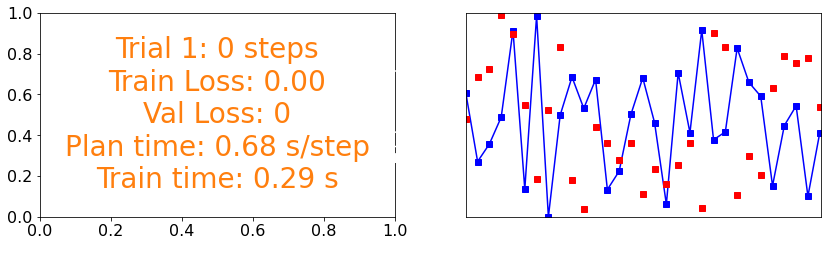

In [12]:
def update_axes(_axs, _frame, _text, _trial, _steps_trial, _plan_time, _train_time, _all_rewards, _goal_reached, _train_loss, _val_loss, force_update=False):
    if not force_update and (_steps_trial % 10 != 0):
        return
    _axs[0].imshow(_frame)
    _axs[0].set_xticks([])
    _axs[0].set_yticks([])
    _axs[0].tick_params(axis='x', colors='white')
    _axs[0].tick_params(axis='y', colors='white')
    _axs[1].clear()
    _axs[1].set_xlim([0, num_trials + .1])
    _axs[1].set_ylim([min(_all_rewards), 0])
    _axs[1].set_xlabel("Trial")
    _axs[1].set_ylabel("Trial reward")
    _axs[1].xaxis.label.set_color('white')
    _axs[1].yaxis.label.set_color('white')
    _axs[1].tick_params(axis='x', colors='white')
    _axs[1].tick_params(axis='y', colors='white')
    _axs[1].plot(_all_rewards, 'bs-', _goal_reached, 'rs')
    _text.set_text("Trial {}: {} steps\nTrain Loss: {:.2f}\nVal Loss: {:.3g}\nPlan time: {:.2f} s/step\nTrain time: {:.2f} s".format(_trial + 1, _steps_trial, _train_loss, _val_loss, _plan_time, _train_time))
    display.display(plt.gcf())  
    display.clear_output(wait=True)

text_kwargs = dict(ha='center', va='center', fontsize=28, color='C1')
def update_axes_text(_axs, _trial, _steps_trial, _plan_time, _train_time, _all_rewards, _goal_reached, _train_loss, _val_loss, force_update=False):
    if not force_update and (_steps_trial % 10 != 0):
        return
    _axs[0].clear()
    _axs[0].text(0.5, 0.5, 
    "Trial {}: {} steps\nTrain Loss: {:.2f}\nVal Loss: {:.3g}\nPlan time: {:.2f} s/step\nTrain time: {:.2f} s".format(_trial + 1, _steps_trial, _train_loss, _val_loss, _plan_time, _train_time), **text_kwargs)
    _axs[1].clear()
    _axs[1].set_xlim([0, num_trials + .1])
    _axs[1].set_ylim([min(_all_rewards), 0])
    _axs[1].set_xlabel("Trial")
    _axs[1].set_ylabel("Trial reward")
    _axs[1].xaxis.label.set_color('white')
    _axs[1].yaxis.label.set_color('white')
    _axs[1].tick_params(axis='x', colors='white')
    _axs[1].tick_params(axis='y', colors='white')
    _axs[1].plot(_all_rewards, 'bs-', _goal_reached, 'rs')
    display.display(plt.gcf())  
    display.clear_output(wait=True)

# Test plot function
env.reset()
fig, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
ax_text = axs[0].text(130, 80, "")
ax_text.set_color('white')
all_rewards = np.random.randint(-500, 0, num_trials + 1)
goal_reached = np.random.randint(-500, 0, num_trials + 1)
steps = np.sort(np.random.randint(0,10000, len(all_rewards)))
plan_time = np.random.rand()
train_time = np.random.rand()
# update_axes(axs,env.render(mode="rgb_array"),  ax_text, 0, 0, plan_time, train_time, all_rewards, goal_reached, train_losses[-1], val_scores[-1], force_update=True)
update_axes_text(axs, 0, 0, plan_time, train_time, all_rewards, goal_reached, train_losses[-1], val_scores[-1], force_update=True)

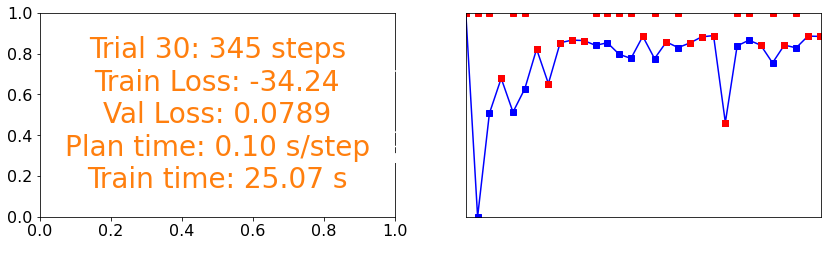

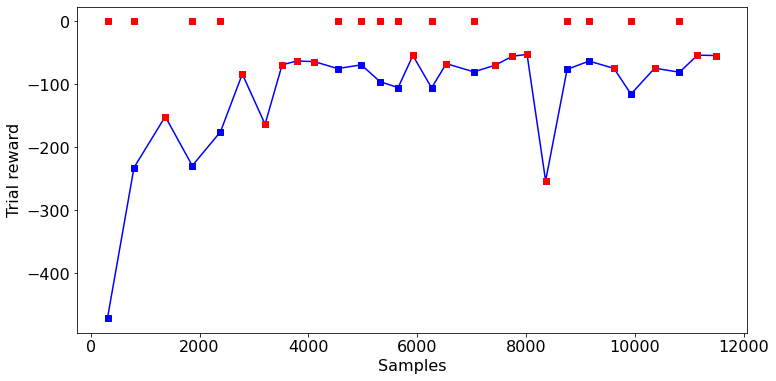

In [13]:
# Create logging folder
print(f"Results will be saved at {work_dir}.")

# Create a trainer for the model
model_trainer = models.ModelTrainer(dynamics_model, optim_lr=1e-3, weight_decay=5e-5)

# Create visualization objects
fig, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
ax_text = axs[0].text(130, 80, "")
ax_text.set_color('white')

# Main PETS loop
all_rewards = [0]
total_steps = [0]
goal_reached = [0]
training_result = []
plan_time = 0.0
train_time = 0.0
for trial in range(num_trials):
    obs = env.reset()    
    agent.reset()
    done = False
    trial_reward = 0.0
    trial_pb_steps = 0.0
    steps_trial = 0

    update_axes_text(axs, trial, steps_trial, plan_time, train_time,
        all_rewards, goal_reached, train_losses[-1], val_scores[-1])
    # update_axes(axs, env.render(mode="rgb_array"), ax_text, trial, steps_trial, plan_time, train_time,
    #     all_rewards, goal_reached, train_losses[-1], val_scores[-1])

    training_result.append(np.hstack([trial, 
                                    steps_trial, 
                                    trial_pb_steps,
                                    obs[0:3] + env.goal_pos_workframe, 
                                    obs[7:10] + env.goal_pos_workframe, 
                                    env.goal_pos_workframe, 
                                    trial_reward, 
                                    False,
                                    done]))

    while not done:

        if steps_trial == 0:
            # --------------- Model Training -----------------
            dynamics_model.update_normalizer(replay_buffer.get_all())  # update normalizer stats            
            dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
                replay_buffer,
                batch_size=cfg.overrides.model_batch_size,
                val_ratio=cfg.overrides.validation_ratio,
                ensemble_size=ensemble_size,
                shuffle_each_epoch=True,
                bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
            )
            
            start_train_time = time.time()
            model_trainer.train(
                dataset_train, 
                dataset_val=dataset_val, 
                num_epochs=50, 
                patience=50, 
                callback=train_callback,
                silent=True)
            train_time = time.time() - start_train_time

            if work_dir is not None:
                dynamics_model.save(str(work_dir))
                replay_buffer.save(work_dir)

        # --- Doing env step using the agent and adding to model dataset ---
        start_plan_time = time.time()
        next_obs, reward, done, info = common_util.step_env_and_add_to_buffer(
            env, obs, agent, {}, replay_buffer)
        plan_time = time.time() - start_plan_time

        update_axes_text(axs, trial, steps_trial, plan_time, train_time,
            all_rewards, goal_reached, train_losses[-1], val_scores[-1])
        # update_axes(
        #     axs, env.render(mode="rgb_array"), ax_text, trial, steps_trial, plan_time, train_time, 
        #     all_rewards, goal_reached,  train_losses[-1], val_scores[-1])

        obs = next_obs
        trial_reward += reward
        trial_pb_steps += info["num_of_pb_steps"]
        steps_trial += 1

        # Save data for plotting training performance
        training_result.append(np.hstack([trial,
                                        steps_trial,
                                        trial_pb_steps * env._sim_time_step,
                                        obs[0:3] + env.goal_pos_workframe, 
                                        obs[7:10] + env.goal_pos_workframe, 
                                        env.goal_pos_workframe, 
                                        trial_reward, 
                                        info["tip_in_contact"],
                                        done]))

        if steps_trial == trial_length:
            break

    all_rewards.append(trial_reward)
    total_steps.append(steps_trial + total_steps[-1])

    # save goal reached data during training
    if env.single_goal_reached:
        goal_reached.append(trial_reward)
    else:
        goal_reached.append(0)

update_axes_text(axs, trial, steps_trial, plan_time, train_time,
    all_rewards, goal_reached, train_losses[-1], val_scores[-1], force_update=True)
# update_axes(axs, env.render(mode="rgb_array"), ax_text, trial, steps_trial, plan_time, train_time, 
#     all_rewards, goal_reached, train_losses[-1], val_scores[-1], force_update=True)

# Plot results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(total_steps[1:], all_rewards[1:], 'bs-', total_steps[1:], goal_reached[1:], 'rs')
ax.set_xlabel("Samples")
ax.set_ylabel("Trial reward")
fig.savefig(os.path.join(work_dir, "output.png"))


In [14]:
def plot_and_save_push_plots(df, trials, directory):
    loss_contact = False
    for trial in range(trials):
        fig_xy, ax = plt.subplots(figsize=(12, 6))
        ax.plot(df.query("trial==@trial")["tcp_x"], df.query("trial==@trial")["tcp_y"], "bs", label='tcp psosition')
        ax.plot(df.query("trial==@trial").query("contact==@loss_contact")["tcp_x"], df.query("trial==@trial").query("contact==@loss_contact")["tcp_y"], "g+", markersize=20)
        ax.plot(df.query("trial==@trial")["contact_x"], df.query("trial==@trial")["contact_y"], "rs", label='contact psosition')
        ax.plot(df.query("trial==@trial").query("contact==@loss_contact")["contact_x"], df.query("trial==@trial").query("contact==@loss_contact")["contact_y"], "gx", markersize=20)
        ax.plot(df.query("trial==@trial")["goal_x"].iloc[0], df.query("trial==@trial")["goal_y"].iloc[0], "x", markersize=20, markeredgecolor="black", label="goal position")
        ax.set_xlabel("x workframe")
        ax.set_ylabel("y workframe")
        ax.set_xlim([0, 0.3])
        ax.set_ylim([-0.1, 0.1])
        ax.legend()
        fig_xy.savefig(os.path.join(directory, "workframe_plot_trial_{}.png".format(trial)))
        plt.close(fig_xy)

        fig_time_xy, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
        axs[0].plot(df.query("trial==@trial")["time_steps"], df.query("trial==@trial")["tcp_x"] - df.query("trial==@trial")["goal_x"], "bs", label='tcp from goal')
        axs[0].plot(df.query("trial==@trial").query("contact==@loss_contact")["time_steps"], df.query("trial==@trial").query("contact==@loss_contact")["tcp_x"] - df.query("trial==@trial").query("contact==@loss_contact")["goal_x"], "g+", markersize=20)
        axs[0].plot(df.query("trial==@trial")["time_steps"], df.query("trial==@trial")["contact_x"] - df.query("trial==@trial")["goal_x"], "rs", label='contact from goal')
        axs[0].plot(df.query("trial==@trial").query("contact==@loss_contact")["time_steps"], df.query("trial==@trial").query("contact==@loss_contact")["contact_x"]- df.query("trial==@trial").query("contact==@loss_contact")["goal_x"], "gx", markersize=20)
        axs[0].set_xlabel("Time steps (s)")
        axs[0].set_ylabel("x axis workframe")
        axs[0].set_ylim([-0.3, 0.1])
        axs[0].legend()
        axs[1].plot(df.query("trial==@trial")["time_steps"], df.query("trial==@trial")["tcp_y"] - df.query("trial==@trial")["goal_y"], "bs", label='tcp')
        axs[1].plot(df.query("trial==@trial").query("contact==@loss_contact")["time_steps"], df.query("trial==@trial").query("contact==@loss_contact")["tcp_y"] - df.query("trial==@trial").query("contact==@loss_contact")["goal_y"], "g+", markersize=20)
        axs[1].plot(df.query("trial==@trial")["time_steps"], df.query("trial==@trial")["contact_y"] - df.query("trial==@trial")["goal_y"], "rs", label='contact from goal')
        axs[1].plot(df.query("trial==@trial").query("contact==@loss_contact")["time_steps"], df.query("trial==@trial").query("contact==@loss_contact")["contact_y"] - df.query("trial==@trial").query("contact==@loss_contact")["goal_y"], "gx", markersize=20)
        axs[1].set_xlabel("Time steps (s)")
        axs[1].set_ylabel("y axis workframe")
        axs[1].set_ylim([-0.2, 0.2])
        axs[1].legend()
        fig_time_xy.savefig(os.path.join(directory, "time_plot_trial_{}.png".format(trial)))
        plt.close(fig_time_xy)

# Save data 
training_result = np.array(training_result)
data_columns = ['trial','trial_steps', 'time_steps', 'tcp_x','tcp_y','tcp_z','contact_x', 'contact_y', 'contact_z', 'goal_x', 'goal_y', 'goal_z', 'rewards', 'contact', 'dones']
df_training = pd.DataFrame(training_result, columns = data_columns)
pd.DataFrame(training_result).to_csv(os.path.join(work_dir, "training_results.csv"))

# Plot the training results
training_result_directory = os.path.join(work_dir, "training_result")
if not os.path.exists(training_result_directory):
    os.mkdir(training_result_directory)
else:
    for filename in os.listdir(training_result_directory):
        file_path = os.path.join(training_result_directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

plot_and_save_push_plots(df_training, num_trials, training_result_directory)

# Evaluation

Terminated at step 336 with reward -281.91933284209523, goal reached: True
Terminated at step 368 with reward -66.76567342582756, goal reached: False
Terminated at step 361 with reward -67.31054473597372, goal reached: True
Terminated at step 288 with reward -139.58976145301935, goal reached: False
Terminated at step 382 with reward -61.35969420575869, goal reached: False
Terminated at step 334 with reward -58.86816098318925, goal reached: True
Terminated at step 379 with reward -63.11446057644338, goal reached: False
Terminated at step 334 with reward -54.31613449061214, goal reached: True
Terminated at step 333 with reward -54.099145073781976, goal reached: True
Terminated at step 325 with reward -55.56027639245151, goal reached: True
Terminated at step 273 with reward -51.01697598814127, goal reached: True
Terminated at step 367 with reward -236.20019669806004, goal reached: False
Terminated at step 330 with reward -53.30858054042877, goal reached: True
Terminated at step 306 with r

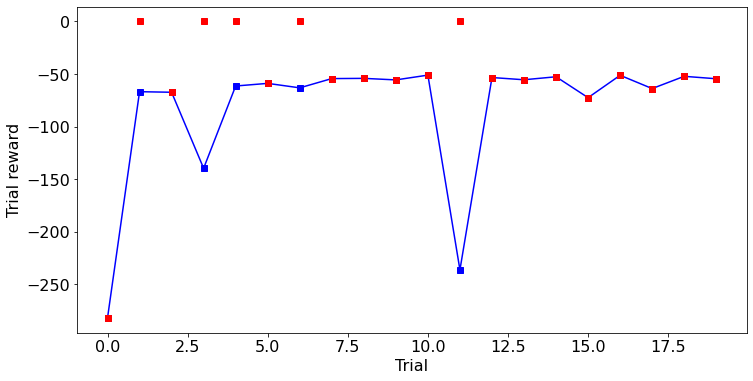

In [16]:
# Main PETS loop
num_test_trials = 20
all_rewards = []
evaluation_result = []
goal_reached = []
plan_time = 0.0
train_time = 0.0
save_vid = True
render = True

if save_vid:
    record_every_n_frames = 1
    render_img = env.render(mode="rgb_array")
    render_img_size = (render_img.shape[1], render_img.shape[0])
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(
        os.path.join(work_dir, "evaluated_policy.mp4"),
        fourcc,
        24.0,
        render_img_size,
    )

for trial in range(num_test_trials):
    obs = env.reset()    
    agent.reset()
    
    done = False
    trial_reward = 0.0
    trial_pb_steps = 0.0
    steps_trial = 0

    evaluation_result.append(np.hstack([trial, 
                                        steps_trial, 
                                        trial_pb_steps,
                                        obs[0:3] + env.goal_pos_workframe, 
                                        obs[7:10] + env.goal_pos_workframe, 
                                        env.goal_pos_workframe, 
                                        trial_reward, 
                                        False,
                                        done]))

    while not done:

        # --- Doing env step using the agent and adding to model dataset ---
        start_plan_time = time.time()
        action = agent.act(obs, **{})
        next_obs, reward, done, info = env.step(action)
        plan_time = time.time() - start_plan_time

        if render:
            render_img = env.render(mode="rgb_array")
        else:
            render_img = None
        
        obs = next_obs
        trial_reward += reward
        trial_pb_steps += info["num_of_pb_steps"]
        steps_trial += 1

        evaluation_result.append(np.hstack([trial, 
                                            steps_trial, 
                                            trial_pb_steps * env._sim_time_step,
                                            obs[0:3] + env.goal_pos_workframe, 
                                            obs[7:10] + env.goal_pos_workframe, 
                                            env.goal_pos_workframe, 
                                            trial_reward, 
                                            info["tip_in_contact"],
                                            done]))
        
         # use record_every_n_frames to reduce size sometimes
        if save_vid and steps_trial % record_every_n_frames == 0:

            # warning to enable rendering
            if render_img is None:
                sys.exit('Must be rendering to save video')

            render_img = cv2.cvtColor(render_img, cv2.COLOR_BGR2RGB)
            out.write(render_img)

        if steps_trial == trial_length:
            break
    
    print("Terminated at step {} with reward {}, goal reached: {}".format(steps_trial, trial_reward, env.single_goal_reached))
    all_rewards.append(trial_reward)

    # save goal reached data during training
    if env.single_goal_reached:
        goal_reached.append(trial_reward)
    else:
        goal_reached.append(0)

if save_vid:
    out.release()

print("The average reward over {} episodes is {}".format(num_test_trials, np.mean(all_rewards)))

# Save data 
evaluation_result = np.array(evaluation_result)
df_evaluation = pd.DataFrame(evaluation_result, columns = data_columns)
pd.DataFrame(evaluation_result).to_csv(os.path.join(work_dir, "evaluation_results.csv"))

# plot evaluation results
evaluation_result_directory = os.path.join(work_dir, "evaluation_result")
if not os.path.exists(evaluation_result_directory):
    os.mkdir(evaluation_result_directory)
else:
    for filename in os.listdir(evaluation_result_directory):
        file_path = os.path.join(evaluation_result_directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

plot_and_save_push_plots(df_evaluation, num_test_trials, evaluation_result_directory)

# Plot evaluation results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(all_rewards, 'bs-', goal_reached, 'rs')
ax.set_xlabel("Trial")
ax.set_ylabel("Trial reward")
fig.savefig(os.path.join(work_dir, "evaluation_output.png"))


# Check model learning and rollout predictions to see if code is correct

# samples stored 10000
Training time:  50.66807413101196
Train Loss: -30.076607167921484, Val Loss: 0.2646161913871765


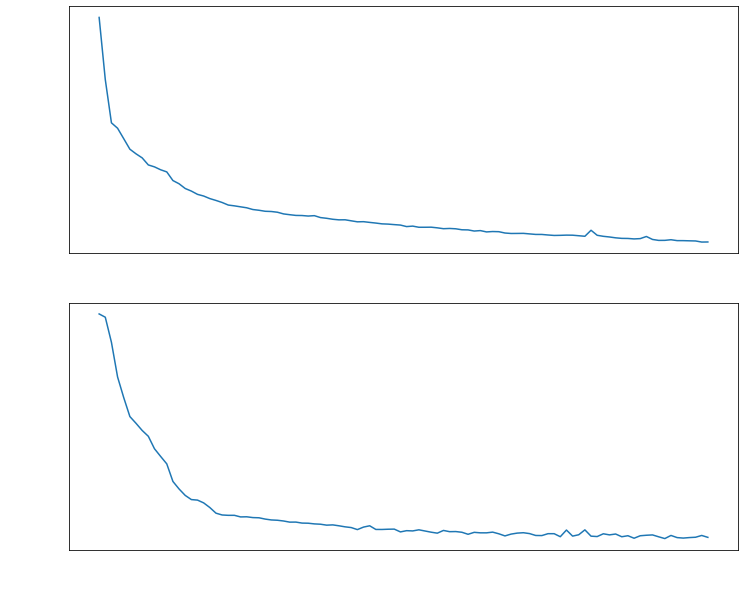

In [12]:
# Test optimisation iterations for CEM
train_losses = []
val_scores = []

# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnvPushing(env, dynamics_model, termination_fn=None, reward_fn=None, generator=generator)

replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)
common_util.rollout_agent_trajectories(
    env,
    buffer_size, # initial exploration steps
    planning.RandomAgent(env),
    {}, # keyword arguments to pass to agent.act()
    replay_buffer=replay_buffer,
    trial_length=trial_length
)

print("# samples stored", replay_buffer.num_stored)

# Train model first
model_trainer = models.ModelTrainer(dynamics_model, optim_lr= 1e-3, weight_decay=5e-5)
dynamics_model.update_normalizer(replay_buffer.get_all())
dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
    replay_buffer,
    batch_size=cfg.overrides.model_batch_size,
    val_ratio=cfg.overrides.validation_ratio,
    ensemble_size=ensemble_size,
    shuffle_each_epoch=True,
    bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
)

start_train_time = time.time()
model_trainer.train(
    dataset_train, 
    dataset_val=dataset_val, 
    num_epochs=100, 
    patience=50, 
    callback=train_callback,
    silent=True)
train_time = time.time() - start_train_time

print("Training time: ", train_time)
print("Train Loss: {}, Val Loss: {}".format(train_losses[-1], val_scores[-1]))

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].plot(train_losses)
ax[0].set_xlabel("Total training epochs")
ax[0].set_ylabel("Training loss (avg. NLL)")
ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[1].plot(val_scores)
ax[1].set_xlabel("Total training epochs")
ax[1].set_ylabel("Validation score (avg. MSE)")
ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
plt.show()

In [14]:
# -------- Test model one set of action sequences from buffer to see exploding -------
# states still occur

planning_horizon = 20

# Get action sequence from buffer
data = replay_buffer.get_all()
action_sequences = data.act[0:planning_horizon,:]
action_sequences = np.tile(action_sequences, (5,1,1)).astype(np.float32)
action_sequences = torch.from_numpy(action_sequences)
# print(action_sequences.shape)

# Initialise state and create model input
initial_state = data.obs[0]
# print(initial_state.shape)
initial_obs_batch = np.tile(initial_state, (5,1)).astype(np.float32)
# print(initial_obs_batch.shape)
model_state = model_env.reset(initial_obs_batch, return_as_np=False)
# print(model_state['propagation_indices'])

batch_size = initial_obs_batch.shape[0]
total_rewards = torch.zeros(batch_size, 1)
terminated = torch.zeros(batch_size, 1, dtype=bool)
model_env.reset_batch_goals(batch_size)

print(data.obs[1][0:3])
print(data.next_obs[1][0:3])
print(data.act[1])

for time_step in range(planning_horizon):
    print(torch.mean(model_state["obs"], 0)[0:3])
    # print(model_state["obs"].shape)
    # print(torch.mean(model_state["obs"]))
    action_for_step = action_sequences[:, time_step, :]
    # print(action_for_step[0])

    # Re-initialise model state from data buffer with every time step (1 step rollouts)
    # Comment out to do planning_horizon step rollouts
    # initial_state = data.obs[time_step]
    # initial_obs_batch = np.tile(initial_state, (5,1)).astype(np.float32)
    # initial_obs_batch = torch.from_numpy(initial_obs_batch)
    # model_state.update({'obs': initial_obs_batch})
    # action_batch = torch.repeat_interleave(
    #     action_for_step, 20, dim=0
    # )

    action_batch = action_for_step
    # ---------------- Use model_env.step -----------------
    # _, rewards, dones, model_state = model_env.step(
    #     action_batch, model_state, sample=True
    # )
    # rewards[terminated] = 0
    # terminated |= dones
    # total_rewards += rewards

    # -------------- Use one_dim_tr_model sample -------------
    # with torch.no_grad():
    #     next_observs, _, _, next_model_state, = model_env.dynamics_model.sample(
    #         action_batch, model_state, deterministic=False, rng=model_env._rng,
    #     )

    # -------------- Use model.sample_1d() --------------------
    # with torch.no_grad():
    #     obs = model_state["obs"]
    #     model_in = model_env.dynamics_model._get_model_input(model_state["obs"], action_batch)
    #     next_observs, _ = model_env.dynamics_model.model.sample_1d(
    #         model_in, model_state, rng=model_env._rng, deterministic=False
    #     )
    #     next_observs += obs
    #     model_state["obs"] = next_observs

    # -------------- Use model.forward()-------------------------
    with torch.no_grad():
        obs = model_state["obs"]
        model_in = model_env.dynamics_model._get_model_input(model_state["obs"], action_batch)
        means, logvars = model_env.dynamics_model.model.forward(
            model_in, rng=model_env._rng, propagation_indices=model_state["propagation_indices"]
        )
        variances = logvars.exp()
        stds = torch.sqrt(variances)
        # stds = torch.ones((5,30))
        next_observs = torch.normal(means, stds, generator=model_env._rng)
        # next_observs = means
        # print(torch.mean(means))
        # print(torch.mean(logvars))
        # print(torch.mean(stds))
        if dynamics_model.target_normalizer:
            next_observs = dynamics_model.target_normalizer.denormalize(next_observs)

        if dynamics_model.target_is_delta:
            next_observs += obs
        model_state["obs"] = next_observs

[-0.288996 0.027655 0.000000]
[-0.288000 0.027377 0.000000]
[0.066521 0.215426]
tensor([-0.2900,  0.0286,  0.0000], device='cuda:0')
tensor([-0.2890,  0.0276,  0.0023], device='cuda:0')
tensor([-2.8800e-01,  2.7374e-02,  1.4141e-04], device='cuda:0')
tensor([-0.2870,  0.0283,  0.0054], device='cuda:0')
tensor([-0.2860,  0.0286,  0.0052], device='cuda:0')
tensor([-0.2850,  0.0295,  0.0078], device='cuda:0')
tensor([-0.2840,  0.0293,  0.0125], device='cuda:0')
tensor([-0.2830,  0.0295,  0.0118], device='cuda:0')
tensor([-0.2820,  0.0304,  0.0136], device='cuda:0')
tensor([-0.2810,  0.0313,  0.0150], device='cuda:0')
tensor([-0.2800,  0.0308,  0.0197], device='cuda:0')
tensor([-0.2790,  0.0301,  0.0168], device='cuda:0')
tensor([-0.2780,  0.0291,  0.0165], device='cuda:0')
tensor([-0.2770,  0.0294,  0.0138], device='cuda:0')
tensor([-0.2760,  0.0289,  0.0147], device='cuda:0')
tensor([-0.2751,  0.0283,  0.0129], device='cuda:0')
tensor([-0.2741,  0.0278,  0.0123], device='cuda:0')
tensor(